In [42]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


In [43]:
# Parallelization
dde.config.set_parallel_scaling('weak') # Nao paralelo
# dde.config.set_parallel_scaling('strong') # Ativa paralelização

In [44]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2
v_i = 0

Re = rho * u_in * D / mu
Re

1.0

In [45]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [46]:
def upper_wall(X, on_boundary):
  on_upper_wall = np.logical_and(np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)), on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  on_lower_wall = np.logical_and(np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [47]:
def zero(x):
    return 0.

def inlet_u(x):
    return u_in

def wall_u(x):
    return v_i

bc_wall_u_up = dde.DirichletBC(geom, wall_u, upper_wall, component =0)
bc_wall_u_down = dde.DirichletBC(geom, zero, lower_wall, component =0)
bc_wall_v_up = dde.DirichletBC(geom, zero, upper_wall, component =1)
bc_wall_v_down = dde.DirichletBC(geom, zero, lower_wall, component =1)

bc_inlet_u = dde.DirichletBC(geom, inlet_u, boundary_inlet, component =0)
bc_inlet_v = dde.DirichletBC(geom, zero, boundary_inlet, component =1)

bc_outlet_p = dde.DirichletBC(geom, zero, boundary_outlet, component =2)
bc_outlet_v = dde.DirichletBC(geom, zero, boundary_outlet, component =1)

In [48]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    # Definições para newtoniano para componentes do tensor de tensão
    tau_xy =  mu * (du_y + dv_x)
    tau_xx =  2 * mu * du_x
    tau_yx =  mu * (dv_x + du_y)
    tau_yy =  2 * mu * dv_y

    # Derivadas dos tensores de tensão
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_xy_x = dde.grad.jacobian(tau_xy, X, i=0, j=0)
    dtau_yx_y = dde.grad.jacobian(tau_yx, X, i=0, j=1)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Termos de advecção para as componentes u e v
    advec_u = Y[:,0:1] * du_x + Y[:,1:2] * du_y
    advec_v = Y[:,0:1] * dv_x + Y[:,1:2] * dv_y
    
    # Tensões na particula fluida
    tensao_x =  dp_x -  dtau_yx_y - dtau_xx_x
    tensao_y =  dp_y -  dtau_xy_x - dtau_yy_y

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * advec_u + tensao_x
    pde_v = rho * advec_v + tensao_y
    
    # Equação de continuidade
    pde_cont = du_x + dv_y  

    return [pde_u, pde_v, pde_cont]

In [49]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u_up,bc_wall_u_down,bc_wall_v_up,bc_wall_v_down,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 2500,
                    num_boundary = 500,
                    num_test = 2000)

<function matplotlib.pyplot.show(close=None, block=None)>

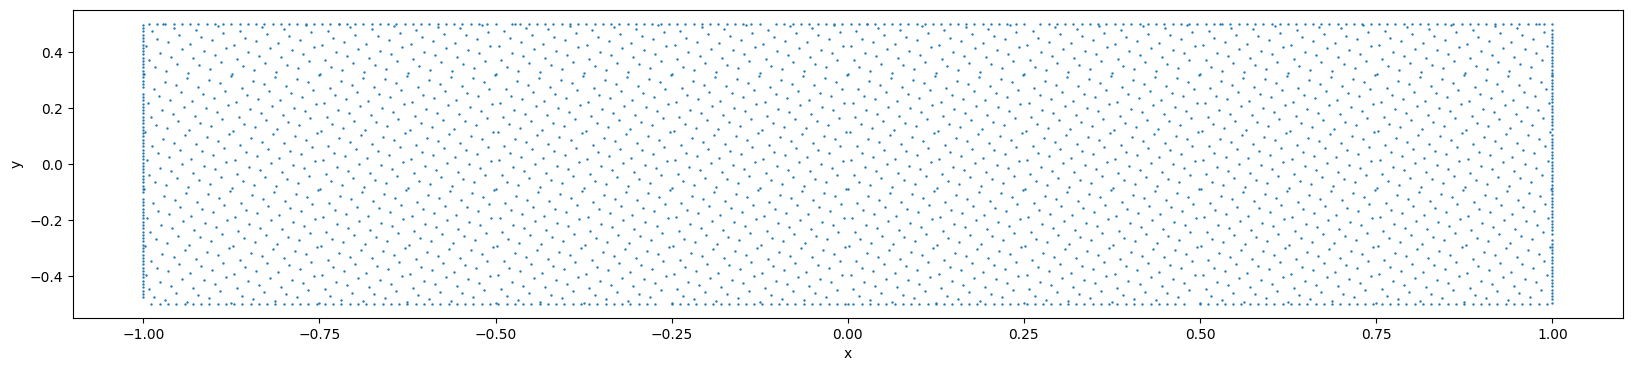

In [50]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [51]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [52]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000540 s



In [53]:
losshistory,train_state = model.train(iterations = 10000, display_every=100)

Training model...



c:\Users\Pablo\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-4PBOT-FI-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0         [1.74e-01, 3.12e-02, 2.89e-01, 7.68e-02, 7.69e-02, 1.61e-02, 1.58e-02, 4.13e-01, 2.36e-02, 1.51e-01, 2.40e-02]    [1.76e-01, 2.85e-02, 2.95e-01, 7.68e-02, 7.69e-02, 1.61e-02, 1.58e-02, 4.13e-01, 2.36e-02, 1.51e-01, 2.40e-02]    []  
100       [7.43e-03, 6.56e-04, 2.28e-02, 7.99e-02, 8.16e-02, 1.39e-02, 1.56e-02, 1.50e-01, 4.06e-03, 3.86e-05, 4.50e-03]    [6.08e-03, 5.52e-04, 2.30e-02, 7.99e-02, 8.16e-02, 1.39e-02, 1.56e-02, 1.50e-01, 4.06e-03, 3.86e-05, 4.50e-03]    []  
200       [1.74e-02, 1.03e-03, 3.51e-02, 6.53e-02, 6.05e-02, 1.19e-02, 1.17e-02, 1.16e-01, 4.79e-03, 7.40e-07, 1.67e-03]    [1.26e-02, 7.12e-04, 3.34e-02, 6.53e-02, 6.05e-02, 1.19e-02, 1.17e-02, 1.16e-01, 4.79e-03, 7.40e-07, 1.67e-03]    []  
300       [1.27e-02, 9.83e-04, 5.47e-02, 7.29e-02, 6.59e-02, 1.07e-02, 1.32e-02, 5.20e-02, 8.73e-03, 1.08e-04, 2.17e-05]    [7.99e-03, 6.87e-04, 5.15e-02, 7.29e-02, 6.59e-02, 1.07e-02, 1.32e-02, 5.20e-02, 8.73e-03, 1.08e-04, 2.17e-05]    []  
400       [3.36e-03, 1.11e-0

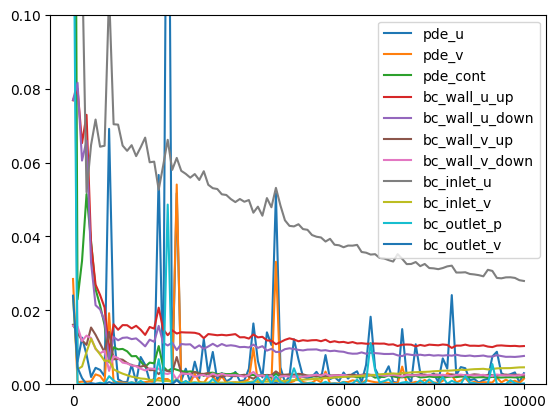

In [54]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [55]:
# dde.optimizers.config.set_LBFGS_options(maxiter = 3000)
model.compile("L-BFGS")
losshistory,train_state = model.train(iterations=3000, display_every=100)
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

model.save("./out/placa_plana", protocol="backend")

Compiling model...
'compile' took 0.062586 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
10000     [4.02e-03, 1.93e-03, 4.32e-03, 1.03e-02, 7.66e-03, 2.32e-03, 2.66e-03, 2.79e-02, 4.59e-03, 2.30e-04, 1.06e-05]    [2.99e-03, 1.51e-03, 1.92e-03, 1.03e-02, 7.66e-03, 2.32e-03, 2.66e-03, 2.79e-02, 4.59e-03, 2.30e-04, 1.06e-05]    []  
15911     [6.14e-04, 4.59e-04, 8.37e-04, 2.88e-03, 6.59e-04, 8.09e-04, 5.51e-04, 4.52e-03, 1.38e-03, 3.45e-05, 1.14e-05]    [6.83e-04, 5.28e-04, 5.54e-04, 2.88e-03, 6.59e-04, 8.09e-04, 5.51e-04, 4.52e-03, 1.38e-03, 3.45e-05, 1.14e-05]    []  

Best model at step 15911:
  train loss: 1.28e-02
  test loss: 1.26e-02
  test metric: []

'train' took 3044.159569 s



'./out/placa_plana-15911.ckpt'

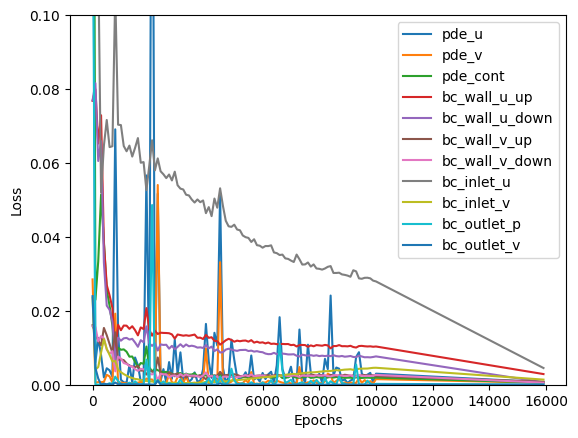

In [56]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 0.1])
plt.show()

In [75]:
import numpy as np
import pandas as pd

n_points = 1000
x2 = np.linspace(-D/2, D/2, n_points)
samples = np.zeros((n_points, 2))
samples[:, 1] = x2

result = model.predict(samples)

probe_points = np.array([[L/2 - 0.01, 0], [L/2 - 0.5, 0]])
probe_pressao = model.predict(probe_points)

delta_p = probe_pressao[0,2] - probe_pressao[1,2]
length = probe_points[0, 0] - probe_points[1, 0]

def u_analytic(x):
    position = x[:, 1] - x[:, 1].min()
    return np.array(1 / mu * (position ** 2 / 2 * delta_p / length + (mu * v_i / D - D / 2 * delta_p / length) * position), dtype=np.float32)

u_exact = u_analytic(samples).reshape(-1)

f = model.predict(samples, operator=pde)
l2_diff_u = dde.metrics.l2_relative_error(u_exact, result[:, 0])
residual = np.mean(np.absolute(f))

result_df = pd.DataFrame({"residual": [residual], "l2_diff_u": [l2_diff_u]})
result_df

,residual,l2_diff_u
0,0.010113,0.002996


C:\Users\Pablo\AppData\Local\Temp\ipykernel_18268\3990802965.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


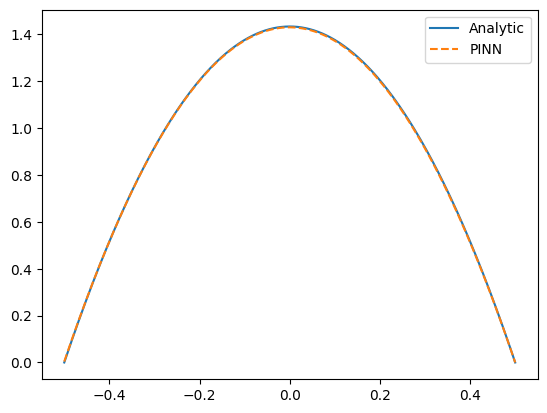

In [76]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(samples[:, 1], u_exact, label="Analytic")
ax.plot(samples[:, 1], result[:, 0], label="PINN", linestyle="dashed")
ax.legend()
fig.show()

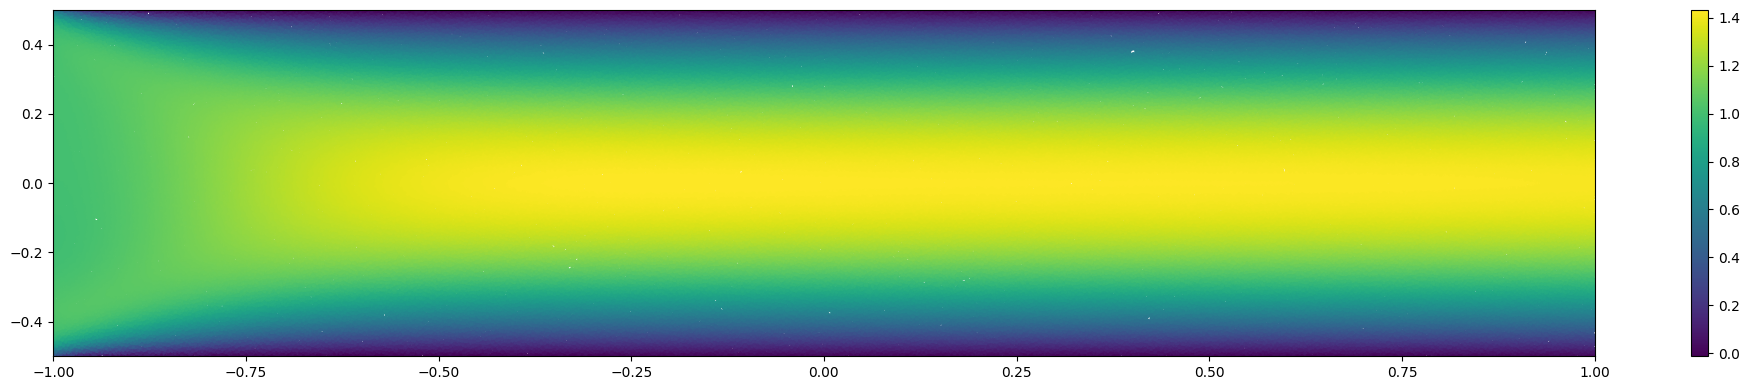

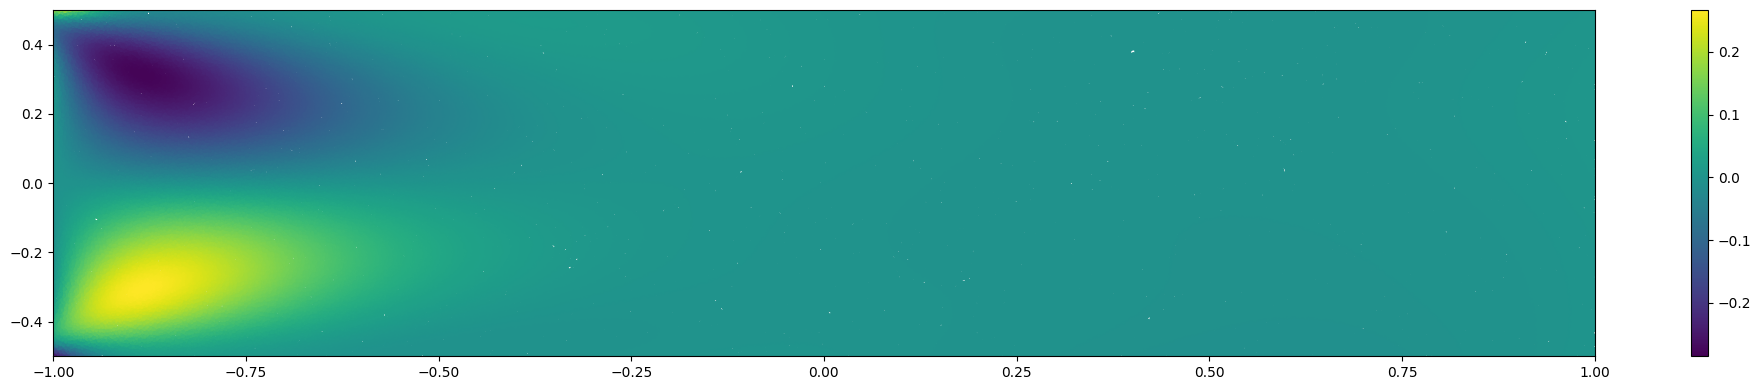

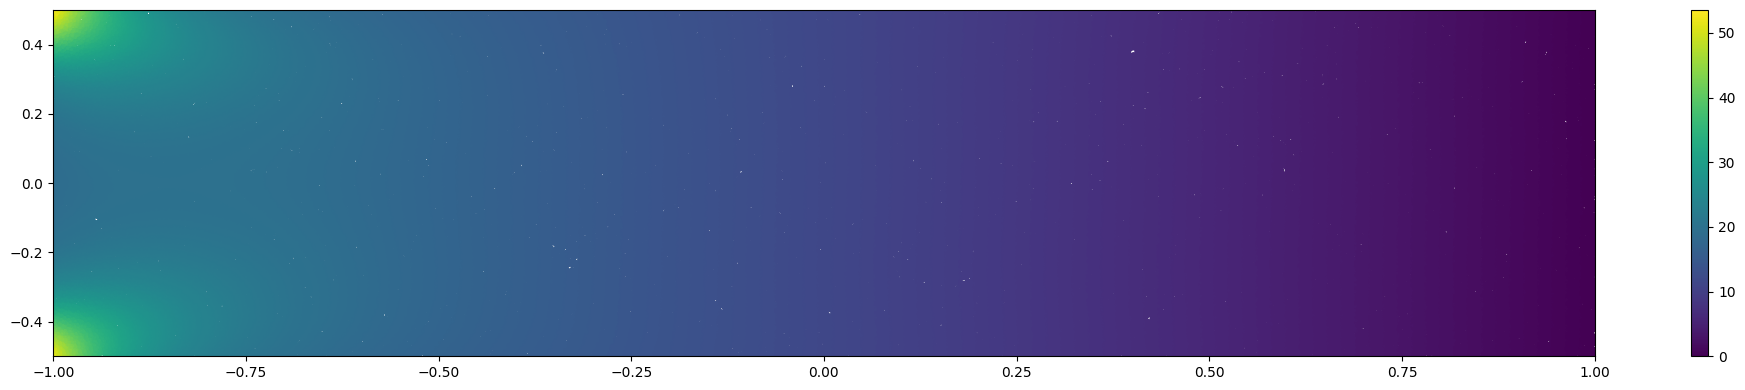

In [79]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

samples= geom.random_points(500000)
result = model.predict(samples)

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'viridis',
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()